In [1]:
from collections import defaultdict
import textwrap
import warnings
import json
from itertools import chain
from functools import partial, reduce
from importlib import reload
from pathlib import Path
from pprint import pprint

import clip
import matplotlib.pyplot
import matplotlib.pyplot as plt
import medmnist
import numpy as np
import torch
from opendataval import dataval
from opendataval.dataloader import DataFetcher
from opendataval.dataval import (
    DataOob,
    DataShapley,
    KNNShapley,
    LavaEvaluator,
    LeaveOneOut,
    RandomEvaluator,
    RobustVolumeShapley,
)
from opendataval.model import ClassifierSkLearnWrapper, RegressionSkLearnWrapper
from scipy.stats import kendalltau, pearsonr
from sklearn import random_projection
from sklearn.decomposition import PCA
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.cluster import homogeneity_score
from sklearn.metrics import DistanceMetric, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, Normalizer
from torchvision.transforms import Compose, ToPILImage
from tqdm.notebook import tqdm
from vendi_score import vendi


import sys
sys.path.append("../src")
import valuation

plt.rcParams["font.family"] = "serif"
fig_dir = Path("../figures")

[KeOps] Warning : cuda was detected, but driver API could not be initialized. Switching to cpu only.


In [2]:
saved_embedding_path = Path("../embeddings")

imagenet = {
    'ImageNet': torch.load(saved_embedding_path / 'clip_embedding_imagenet_original.pt'),
    'ImageNet V2': torch.load(saved_embedding_path / 'clip_embedding_imagenet_v2.pt'),
    'ImageNet-A': torch.load(saved_embedding_path / 'clip_embedding_imagenet_a.pt'),
    'ImageNet-R': torch.load(saved_embedding_path / 'clip_embedding_imagenet_r.pt'),
    'ImageNet-Sketch': torch.load(saved_embedding_path / 'clip_embedding_imagenet_s.pt'),
}

medmnist = {
    "MedMNIST (blood)": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_bloodmnist_224.pt"
    ),
    "MedMNIST (breast)": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_breastmnist_224.pt"
    ),
    "MedMNIST (chest)": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_chestmnist_224.pt"
    ),
    "MedMNIST (derma)": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_dermamnist_224.pt"
    ),
    "MedMNIST (path)": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_pathmnist_224.pt"
    ),
    "MedMNIST (retina)": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_retinamnist_224.pt"
    ),
    "MedMNIST (tissue)": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_tissuemnist_224.pt"
    ),
    "MedMNIST (organ)": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_organamnist_224.pt"
    ),
}

exclude = {
    "MedMNIST (breast)",
    'MedMNIST (derma)',
    'MedMNIST (chest)',
    'MedMNIST (retina)',
}
medmnist = {k: v for k, v in medmnist.items() if k not in exclude}

MedMNIST (organ)


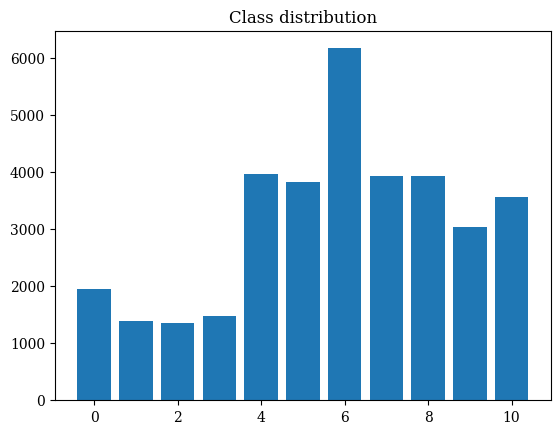

In [3]:
dataset = imagenet['ImageNet']
# dataset = medmnist['MedMNIST (path)']
buyer = list(medmnist.keys())[3]
dataset = medmnist[buyer]
print(buyer)
x = dataset['embeddings']
y = dataset['labels']

plt.figure()
plt.title('Class distribution')
plt.bar(sorted(torch.unique(y)), torch.bincount(y))
plt.xticks(rotation=0)
plt.show()

In [4]:
def sample_dirichlet_by_class(
    x, y, num_sellers=10, num_samples=1000, add_to_alpha=0.1, min_samples=1
):
    """
    Sample seller data according to dirichlet class distribution
    taking into consideration class frequency
    """
    num_classes = len(np.unique(y))
    assert num_samples > min_samples * num_classes, 'not enough samples for minimum class'
    
    y = y.squeeze().numpy()
    class_counts = np.bincount(y)
    class_prop = class_counts / class_counts.sum()
    class_weights = np.random.dirichlet(add_to_alpha + class_prop, size=num_sellers)
    sample_weights = {i: v[y] for i, v in enumerate(class_weights)}
    sample_weights = {k: v / v.sum() for k, v in sample_weights.items()}


    rang = np.arange(len(x))
    seller_indexes = {
        k: np.random.choice(rang, size=num_samples, replace=False, p=v)
        for k, v in sample_weights.items()
    }
    if min_samples > 0:
        for k in seller_indexes.keys():
            new_index = []
            for i, c in enumerate(np.unique(y)):
                class_index = np.where(y == c)[0]
                np.random.shuffle(class_index)
                new_index.extend(class_index[:min_samples])

            seller_indexes[k][: len(new_index)] = new_index

    return seller_indexes

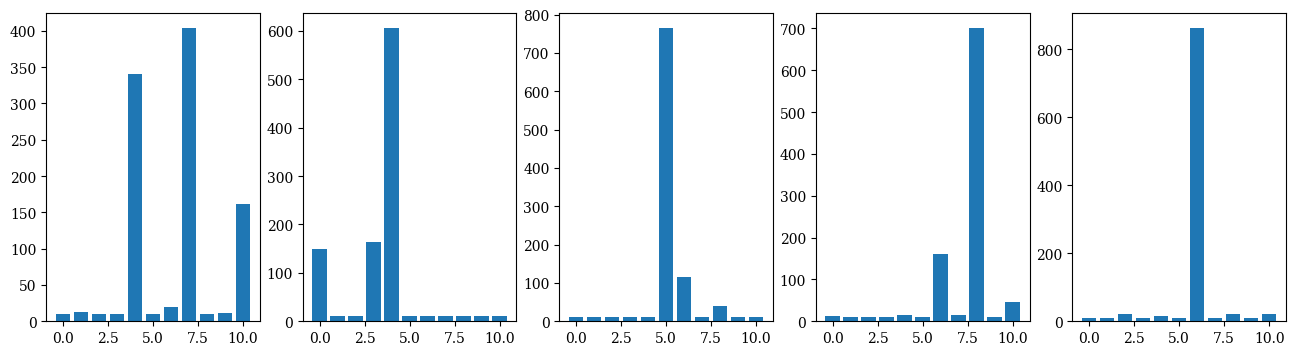

In [5]:
sample = sample_dirichlet_by_class(x, y, add_to_alpha=0, min_samples=10, num_samples=1000)
fig, axes = plt.subplots(1, 5, figsize=(16, 4))
for j, ax in enumerate(axes): ax.bar(*zip(*enumerate(y[sample[j]].bincount())))

In [6]:
def compute_utility(
    x_train,
    y_train,
    x_test,
    y_test,
    model=partial(LogisticRegression, max_iter=200),
    # utility=accuracy_score,
    utility=partial(f1_score, average="macro"),
    # utility=partial(f1_score, average=None),
    model_kwargs=None,
):
    M = model(**model_kwargs) if model_kwargs is not None else model()
    M.fit(x_train, y_train)
    y_pred = M.predict(x_test)
    return utility(y_test, y_pred)

binary_utility = partial(
    compute_utility,
    model=partial(LogisticRegression, max_iter=200),
    utility=accuracy_score,
)
multi_utility = partial(
    compute_utility,
    model=partial(RandomForestClassifier, n_estimators=10, max_depth=5),
    utility=accuracy_score,
)
cluster_utility = partial(
    compute_utility,
    model=partial(KMeans, n_init="auto"),
    utility=lambda true, pred: homogeneity_score(true.squeeze(), pred.squeeze()),
)

In [7]:
def get_model_valuation(
    x_train, y_train, 
    x_val, y_val, 
    task='bin', 
    value_method="KNNShapley", 
    num_classes=2, 
    # num_train=100, 
    return_data_values=False,
):
    """
    Get data valuation from centralized baseline using OpenDataVal framework
    """ 
    wrap = ClassifierSkLearnWrapper
    if task == "bin":
      pred_model = wrap(LogisticRegression, num_classes=2, max_iter=100)
    elif task == "multi":
      pred_model = wrap(RandomForestClassifier, num_classes=num_classes, n_estimators=10, max_depth=5)
    else:
      pred_model = wrap(KMeans, num_classes=num_classes, n_clusters=num_classes, n_init='auto')

    fetcher = DataFetcher.from_data_splits(
        x_train, y_train, x_val, y_val, x_val, y_val, one_hot=False
    )

    valuer = getattr(dataval, value_method)()
    valuer.train(fetcher=fetcher, pred_model=pred_model)
    data_values = valuer.data_values
    seller_value = np.mean(data_values)
    if return_data_values:
        return data_values
    else:
        return seller_value
    

In [8]:
def get_random_class_mask(labels, task='bin'):
    classes = torch.unique(labels)
    if task == 'bin':
        cls_sel = np.random.choice(classes, size=1, replace=False)
    elif task == 'multi':
        K = np.random.choice(range(2, len(classes)), size=1, replace=False)
        cls_sel = np.random.choice(classes, size=K, replace=False)
    elif task == 'cluster': 
        cls_sel = classes
    else:
        raise ValueError(task)
    if not isinstance(cls_sel, torch.Tensor):
        cls_sel = torch.tensor(cls_sel)
    mask = torch.isin(labels, cls_sel )
    return mask, cls_sel

In [12]:
def run_experiment(
    x_data, y_data,
    task = 'bin',
    num_test=1000,
    num_buyer=100, 
    num_sellers=50,
    num_samples=5000,
    num_train=1000,
    num_trials=10,
    baselines=['LavaEvaluator', 'KNNShapley'],
    n_components=5,
    min_samples=1,
    add_to_alpha=0.5,
):
    num_classes = len(torch.unique(y_data))
    results = defaultdict(list)
    results['num_test'] = num_test
    results['num_buyer'] = num_buyer
    results['num_sellers'] = num_sellers
    results['num_samples'] = num_samples
    results['num_trials'] = num_trials
    results['n_components'] = n_components
    results['add_to_alpha'] = add_to_alpha
    
    for random_state in range(num_trials):
        # np.random.seed(random_state) 
        print(str(random_state).center(40, '-'))
        
        # choose random index of classes for buyer distribution
        class_mask, classes_selected = get_random_class_mask(y_data, task=task)
        index = np.arange(len(y_data))
        class_index = index[class_mask]
        np.random.shuffle(class_index)

        # take for buyer query and test set
        buyer_index = class_index[:num_buyer]
        test_index = class_index[num_buyer:num_test + num_buyer]
        x_buyer = x_data[buyer_index]
        y_buyer = y_data[buyer_index]
        x_test = x_data[test_index]
        y_test = y_data[test_index]

        # use leftover data to sample sellers 
        samp_index = np.concatenate([
            class_index[num_test + num_buyer:], index[~class_mask]
        ])
        print(class_mask)
        # assert (~class_mask).sum()
        np.random.shuffle(samp_index)
        x_samp = x_data[samp_index]
        y_samp = y_data[samp_index]

        seller_measurements = {}
        seller_data_values = {}
        seller_test_utility = {}

        # generate sellers from dirichelet distribution 
        sellers = sample_dirichlet_by_class(
            x_samp, y_samp, num_sellers=num_sellers, 
            num_samples=num_samples, min_samples=min_samples,
            add_to_alpha=add_to_alpha,
        )
        
        # for j, index in tqdm(sellers.items()):
        for j, index in sellers.items():
            x_seller = x_samp[index]
            y_seller = y_samp[index]

            # store seller data measurements 
            seller_measurements[j] = valuation.get_measurements(x_buyer, x_seller, n_components=n_components)

            # store data values from centralized baselines
            x_train, x_val, y_train, y_val = train_test_split(x_seller.numpy(), y_seller.numpy(), train_size=num_train)
            seller_data_values[j] = {
                value_method: get_model_valuation(
                    x_train, y_train, x_val, y_val, 
                    task=task, value_method=value_method, num_classes=num_classes,
                )
                for value_method in baselines
            }

            # train model on seller data and evaluate utility on buyer's test set
            if not isinstance(classes_selected, torch.Tensor):
                classes_selected = torch.tensor(classes_selected)
            seller_label_mask = torch.isin(y_seller, classes_selected)
            test_label_mask = torch.isin(y_test, classes_selected)
            if not seller_label_mask.any():
                print(classes_selected)
                print(torch.bincount(y_seller))
            assert seller_label_mask.any(), f'missing positive classes in seller. check there is enough samples'
            if task == 'bin':
                # y_seller_bin = torch.where(seller_label_mask, 1, 0)
                # y_test_bin = torch.where(test_label_mask, 1, 0)
                utility = binary_utility(x_seller, seller_label_mask, x_test, test_label_mask)
            elif task == 'multi':
                # set rest of classes to negative
                # y_seller_multi = torch.where(seller_label_mask, y_seller, -1) 
                # assert (y_test_multi == -1).sum() == 0
                # utility = multi_utility(x_seller, y_seller_multi, x_test, y_test_multi)
                utility = multi_utility(x_seller, y_seller, x_test, y_test)
            elif task == 'cluster':
                utility = cluster_utility(x_seller, y_seller, x_test, y_test, model_kwargs={'n_clusters': num_classes})
                seller_label_mask = torch.ones_like(y_seller)
            else: 
                raise ValueError(task)
                
            seller_test_utility[j] = {
                'utility': utility,
                'percent_relevant_samples': seller_label_mask.sum().item() / len(seller_label_mask),
            }
        results['classes_selected'].append(classes_selected.tolist())
        results['measurements'].append(seller_measurements)
        results['data_values'].append(seller_data_values)
        results['test_utility'].append(seller_test_utility)
    return dict(results)
   

In [13]:
res_dir = Path('../results')

In [ ]:
# task = 'bin'
# task = 'multi'
for task in ['bin', 'multi', 'cluster']:
    for name, data in medmnist.items():
        file_name = res_dir / f"newest-{name.replace(' ', '-')}-{task}-task.json"
        if file_name.exists():
            print(f'Already found {file_name}! \nSkipping..')
            continue

        
        print(name.center(40, '='))
        res = run_experiment(
            dataset['embeddings'],
            dataset['labels'],
            task = task,
            num_test=500,
            num_buyer=100, 
            num_sellers=250,
            num_samples=5000,
            num_train=1000,
            num_trials=10,
            baselines=['LavaEvaluator', 'KNNShapley'],
            n_components=10,
            min_samples=5, 
            add_to_alpha=0.5
        )
        
        with open(file_name, 'w') as f:
            f.write(json.dumps(res, default=float, indent=2))

============MedMNIST (blood)============
-------------------0--------------------
tensor([False, False, False,  ..., False, False, False])


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:22<00:00, 44.74it/s]


-------------------1--------------------
tensor([False, False, False,  ..., False, False, False])


 19%|████████████████████████████████▉                                                                                                                                              | 188/999 [00:03<00:16, 48.98it/s]

In [1]:
results = list(res_dir.glob('*.json'))
for i, v in enumerate(results):
    print(i, v)


NameError: name 'res_dir' is not defined

In [13]:
def get_avg_corr(res, rank=False):
    N = len(res['measurements'])
    meas = res['measurements']
    val  = res['data_values']
    util = res['test_utility']
    correlations = defaultdict(list)
    corr_func = kendalltau if rank else pearsonr
    for j in range(N):
        vol = [v['volume'] for v in meas[j].values()]
        over = [v['overlap'] for v in meas[j].values()]
        knn = [-v['KNNShapley'] for v in val[j].values()]
        lava = [v['LavaEvaluator'] for v in val[j].values()]
        y = [v['utility'] for v in util[j].values()]
        correlations['volume'].append(corr_func(vol, y).statistic)
        correlations['overlap'].append(corr_func(over, y).statistic)
        correlations['knn'].append(corr_func(knn, y).statistic)
        correlations['lava'].append(corr_func(lava, y).statistic)
    return {k: (np.mean(v), np.std(v)) for k, v in correlations.items()}


for i, v in enumerate(sorted(results)):
    if 'newest-' not in v.stem: continue
    res = json.load(open(v))
    print(v.stem)
    for k, v in get_avg_corr(res).items():
        print(f'{k}'.ljust(12), round(v[0], 2), '\t', round(v[1], 2))
    print()

new-MedMNIST-(blood)-bin-task
volume       0.25 	 0.17
overlap      -0.01 	 0.11
knn          0.06 	 0.14
lava         0.0 	 0.06

new-MedMNIST-(blood)-cluster-task
volume       0.53 	 0.06
overlap      0.34 	 0.09
knn          0.03 	 0.1
lava         0.01 	 0.06

new-MedMNIST-(blood)-multi-task
volume       0.35 	 0.09
overlap      0.25 	 0.15
knn          0.05 	 0.12
lava         0.0 	 0.06

new-MedMNIST-(organ)-bin-task
volume       0.28 	 0.11
overlap      -0.06 	 0.1
knn          0.08 	 0.13
lava         -0.01 	 0.06

new-MedMNIST-(organ)-cluster-task
volume       0.51 	 0.03
overlap      0.34 	 0.07
knn          0.03 	 0.06
lava         0.01 	 0.06

new-MedMNIST-(organ)-multi-task
volume       0.4 	 0.14
overlap      0.3 	 0.13
knn          0.15 	 0.16
lava         0.01 	 0.05

new-MedMNIST-(path)-bin-task
volume       0.19 	 0.15
overlap      0.03 	 0.14
knn          0.09 	 0.12
lava         0.03 	 0.05

new-MedMNIST-(path)-cluster-task
volume       0.55 	 0.05
overlap      0.31

In [74]:
k = 14
res = json.load(open(results[k]))
print(results[k])

../results/new-MedMNIST-(organ)-multi-task.json


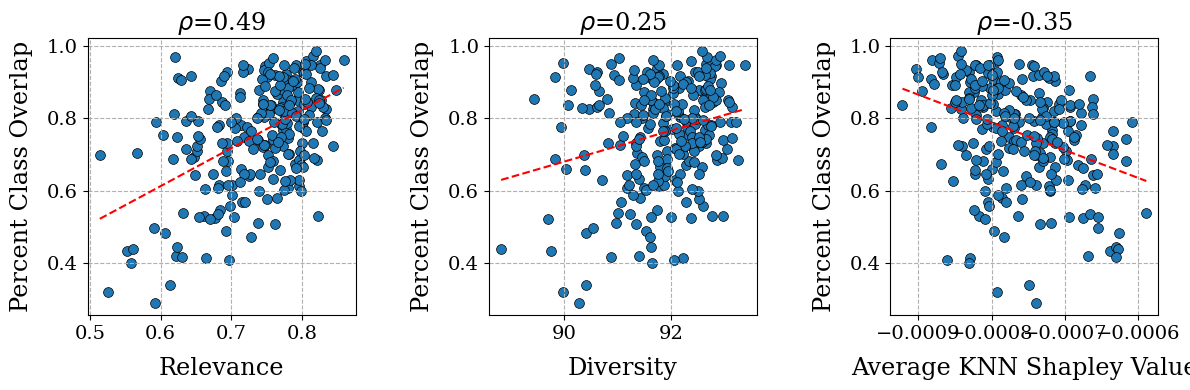

In [90]:
# x = list(chain(*[[v['volume'] for v in res['measurements'][j].values()] for j in range(res['num_trials'])]))
# # x = list(chain(*[[v['overlap'] for v in res['measurements'][j].values()] for j in range(res['num_trials'])]))
# # x = list(chain(*[[v['KNNShapley'] for v in res['data_values'][j].values()] for j in range(res['num_trials'])]))
# # x = list(chain(*[[v['LavaEvaluator'] for v in res['data_values'][j].values()] for j in range(res['num_trials'])]))
# x = list(chain(*[[v['percent_relevant_samples'] for v in res['test_utility'][j].values()] for j in range(res['num_trials'])]))
# y = list(chain(*[[v['utility'] for v in res['test_utility'][j].values()] for j in range(res['num_trials'])]))

j = 5
x_vol = [v['volume'] for v in res['measurements'][j].values()] 
x_over = [v['overlap'] for v in res['measurements'][j].values()] 
x_knn = [-v['KNNShapley'] for v in res['data_values'][j].values()] 
x_lava = [v['LavaEvaluator'] for v in res['data_values'][j].values()] 
y_util = [v['utility'] for v in res['test_utility'][j].values()] 
y_per = [v['percent_relevant_samples'] for v in res['test_utility'][j].values()] 

def fit_line(x, y, poly=1):
    coeff = np.polyfit(x, y, poly)
    polynomial = np.poly1d(coeff)
    x_fit = np.linspace(min(x), max(x), 100)
    y_fit = polynomial(x_fit)
    return x_fit, y_fit

# r = pearsonr(x, y)
# t = kendalltau(x, y)

fig, ax = plt.subplots(ncols=3, figsize=(12, 4))
ax[0].grid(ls='--')
# ax[0].plot(*fit_line(x_vol, y_util), color="red", label="Fitted curve", ls="--")
# ax[0].plot(*fit_line(x_vol, y_per), color="red", label="Fitted curve", ls="--")
ax[0].plot(*fit_line(x_over, y_per), color="red", label="Fitted curve", ls="--")
ax[0].scatter(
    # x_vol,
    x_over,
    # y_util,
    y_per,
    edgecolors="k",
    lw=0.5,
    s=50,
)
ax[0].set_xlabel('Relevance', fontsize='xx-large', labelpad=10)
ax[0].set_ylabel('Percent Class Overlap', fontsize='xx-large', labelpad=10)
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[0].set_title(
    fr"$\rho$={round(pearsonr(x_over, y_per).statistic, 2)}",
    fontsize='xx-large',
)

ax[1].grid(ls='--')
# ax[0].plot(*fit_line(x_vol, y_util), color="red", label="Fitted curve", ls="--")
ax[1].plot(*fit_line(x_vol, y_per), color="red", label="Fitted curve", ls="--")
# ax[0].plot(*fit_line(x_over, y_per), color="red", label="Fitted curve", ls="--")
ax[1].scatter(
    x_vol,
    # x_over,
    # y_util,
    y_per,
    edgecolors="k",
    lw=0.5,
    s=50,
)
ax[1].set_xlabel('Diversity', fontsize='xx-large', labelpad=10)
ax[1].set_ylabel('Percent Class Overlap', fontsize='xx-large', labelpad=10)
ax[1].tick_params(axis='both', which='major', labelsize=14)
ax[1].set_title(
    fr"$\rho$={round(pearsonr(x_vol, y_per).statistic, 2)}",
    fontsize='xx-large',
)

ax[2].grid(ls='--')
# ax[1].plot(*fit_line(x_knn, y_util), color="red", label="Fitted curve", ls="--")
ax[2].plot(*fit_line(x_knn, y_per), color="red", label="Fitted curve", ls="--")
ax[2].scatter(
    x_knn,
    # y_util,
    y_per,
    edgecolors="k",
    lw=0.5,
    s=50,
)
ax[2].set_xlabel('Average KNN Shapley Value', fontsize='xx-large', labelpad=10)
ax[2].set_ylabel('Percent Class Overlap', fontsize='xx-large', labelpad=10)
ax[2].tick_params(axis='both', which='major', labelsize=14)
ax[2].set_title(
    fr"$\rho$={round(pearsonr(x_knn, y_per).statistic, 2)}",
    fontsize='xx-large',
)
fig.tight_layout(w_pad=4)
# plt.savefig(fig_dir / "medmnist-correlations.eps", bbox_inches='tight')

In [28]:
np.mean([
    # .25, .28,.19,.24
    # -.01, -0.06, 0.03, -0.02
    # 0.06, 0.08, 0.09, 0.05
    # 0, -0.01, 0.03, 0.01
    # 0.35, 0.4, 0.39, 0.46
    # 0.25, 0.30, 0.25, 0.29
    # 0.05, 0.15, 0.07, 0.05
    # 0.0, 0.01, 0.02, -0.01
    # 0.53, 0.51, 0.55, 0.53
    # 0.34, 0.34, 0.31, 0.29
    # 0.03, 0.03, 0, 0
    0.01, 0.01, 0.0, -0.01
])

0.0025